In [1]:
###Ryan Blow
from mynn.activations.relu import relu
from mynn.initializers.normal import normal
from mynn.layers.dense import dense
import numpy as np
from mynn.optimizers.adam import Adam
from mygrad.nnet.losses import margin_ranking_loss 
import mygrad as mg
from pathlib import Path
from mynn.losses.cross_entropy import softmax_cross_entropy
from mynn.layers.dropout import dropout
from mynn.layers.conv import conv
from mygrad.nnet.layers import max_pool
from mynn.initializers.glorot_uniform import glorot_uniform
import pickle

In [2]:
class Model():
    def __init__(self, tendrills):
        """
        Input:
            (N,784)
        Returns:
            dense (N, 90)
        """
        self.conv1 = conv(1, 5, 5, 5, padding=0, weight_initializer=glorot_uniform)
        self.conv2 = conv(5, 10, 5, 5, padding=0, weight_initializer=glorot_uniform)
        self.dense1=dense(160, 700, weight_initializer= normal)
        self.dense2=dense(700, 500, weight_initializer= normal)
        self.dense3=dense(500, 100, weight_initializer= normal)
        self.dense4=dense(100, tendrills, weight_initializer= normal)
        weights1=np.load("dense1.npy")
        self.dense1.weight.data=weights1
        weights2=np.load("dense2.npy")
        self.dense2.weight.data=weights2
        weights3=np.load("dense3.npy")
        self.dense3.weight.data=weights3
        weights4=np.load("dense4.npy")
        self.dense4.weight.data=weights4
    def __call__(self, x):
        """
        
        Put in a (N, 784) array and it outputs it as a (N, 90) array to softmax
        
        
        """
        x = self.conv1(x)
        x = max_pool(x, (2, 2), 2)
        x = self.conv2(x)
        x = max_pool(x, (2, 2), 2)
        x=x.reshape(x.shape[0], 160)
        return self.dense4(relu(self.dense3(relu(self.dense2(relu(self.dense1(x)))))))

    def weights1(self):
        weights=self.dense1.weight.data
        return weights
    def weights2(self):
        weights=self.dense2.weight.data
        return weights
    def weights3(self):
        weights=self.dense3.weight.data
        return weights
    def weights4(self):
        weights=self.dense4.weight.data
        return weights
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        return self.dense1.parameters + self.dense2.parameters + self.dense3.parameters + self.dense4.parameters

In [3]:
###Initializes the dictionary
img_dic={}
root=Path(".")
files=sorted(Path(root / "quickdraw").glob('*.npy'))
for i in range(len(files)):
    img = np.load(str(files[i]))
    true=np.zeros(90)
    true[i]=1
    file_location=str(files[i])
    file_name_npy=file_location[32:]
    file_name=file_name_npy[0:(len(file_name_npy)-4)]
    N = img.shape[0]
    img_lists=[]
    all_imgs = img.reshape((N, 28,28))
    for j in range(N):
        img_single= all_imgs[j]
        img_lists.append([img_single,true])
    image_name=file_name
    img_dic[image_name]=img_lists
print("pickling")

pickling


In [ ]:
'''with open("img.pkl", mode="wb") as opened_file:
    pickle.dump(img_dic, opened_file)
print("Done")
img_dic={}'''

<IPython.core.display.Javascript object>


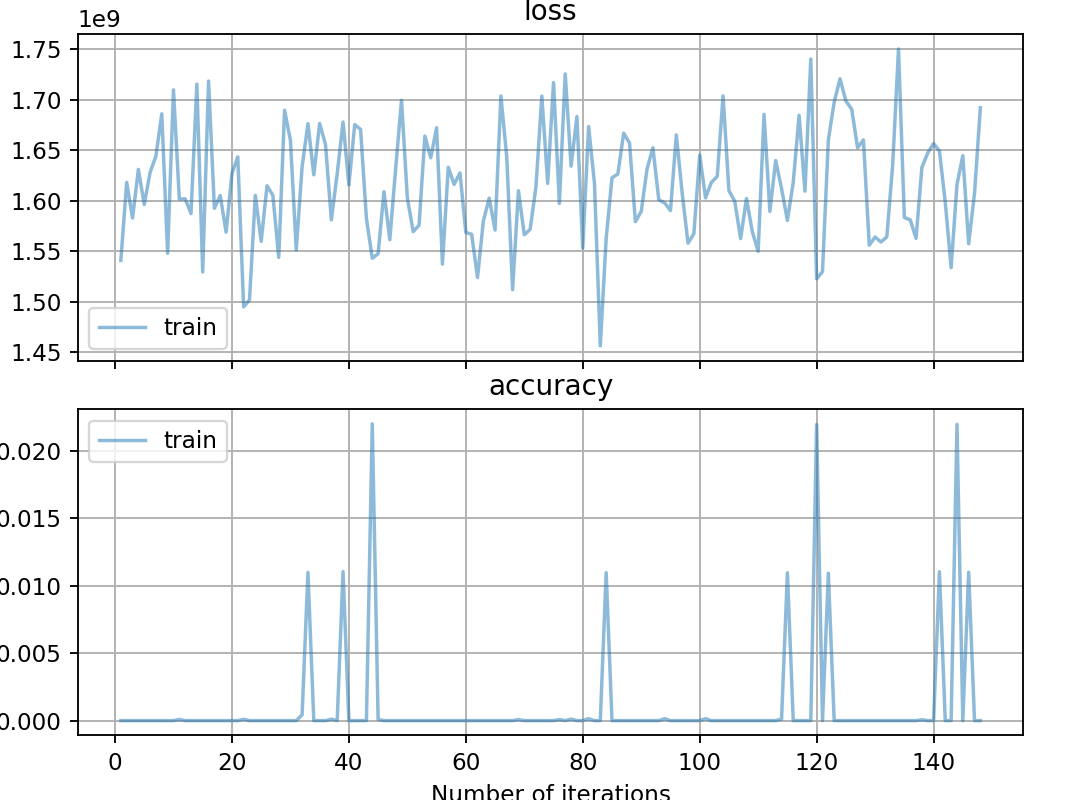

In [8]:
import liveplot
%matplotlib notebook
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=5)

In [5]:
model= Model(len(img_dic.keys()))
opt = Adam(model.parameters)

In [6]:
###the dictionary's values is a list of a list of a list of 2 np arrays
img_values_list=[i for i in img_dic.values()]
#test=28945*90=2605050
#train=115777*90=10419930
#overall=13024980
train_imgs=[]
train_true=[]
test_img=[]
test_true=[]
for i in range(len(img_values_list)):
    for j in range(int(np.around((len(img_values_list[i])*4)/5))):
        train_imgs.append(img_values_list[i][j][0])
        train_true.append(img_values_list[i][j][1])
    for j in range(int(np.around((len(img_values_list[i])*4)/5))+1,len(img_values_list[i])):
        test_img.append(img_values_list[i][j][0])
        test_true.append(img_values_list[i][j][1])
train_imgs=np.array(train_imgs)
train_true=np.array(train_true)
test_img=np.array(test_img)
test_true=np.array(test_true)
img_dic={}
print("done train array making")

done train array making


In [9]:
batch_size = 1000
train_imgs=train_imgs.reshape((train_imgs.shape[0], 1, 28, 28))
test_img=test_img.reshape((test_img.shape[0], 1, 28, 28))
# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(10):
    idxs = np.arange(len(train_imgs))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    for batch_cnt in range(0, len(train_imgs)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = train_imgs[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        prediction=model(batch)
        # compute the true (a.k.a desired) values for this batch: 
        true=train_true[batch_indices]
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        if isinstance(prediction, mg.Tensor):
            prediction = prediction.data
        prediction=list(prediction)
        prediction=np.array(prediction, dtype="int64")
        true=list(true)
        true=np.array(true, dtype="int64")
        prediction=prediction.T
        loss=softmax_cross_entropy(prediction, true)
        # back-propagate through your computational graph through your loss
        loss.backward()
        # compute the accuracy between the prediction and the truth 

        acc=np.mean(np.argmax(prediction, axis=1) == true)
        # execute gradient descent by calling step() of `optim`
        opt.step()
        weights1=model.weights1()
        weights2=model.weights2()
        weights3=model.weights3()
        weights4=model.weights4()
        # null your gradients (please!)
        loss.null_gradients()
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(test_img)//batch_size):
        idxs = np.arange(len(test_img))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = test_img[batch_indices] 
        
        # get your model's prediction on the test-batch
        prediction=model(batch)
        # get the truth values for that test-batch
        true=test_true[batch_indices]
        # compute the test accuracy
        if isinstance(prediction, mg.Tensor):
            prediction = prediction.data
        prediction=list(prediction)
        prediction=np.array(prediction, dtype="int64")
        true=list(true)
        true=np.array(true, dtype="int64")
        acc=np.mean(np.argmax(prediction, axis=1) == true)
        # DO NOT back-prop or do gradient descent!
        
        # log the test-accuracy in liveplot for each-
        plotter.set_test_batch({ "accuracy" : acc},
                                 batch_size=batch_size)
    # this tells liveplot to plot the epoch-level train/test statistics :)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()    
    np.save("dense1.npy", weights1)
    np.save("dense2.npy", weights2)
    np.save("dense3.npy", weights3)
    np.save("dense4.npy", weights4)

MemoryError: 

In [56]:
###Reinitialize the model weights
"""dense1=dense(160, 700, weight_initializer= normal)
dense2=dense(700, 500, weight_initializer= normal)
dense3=dense(500, 100, weight_initializer= normal)
dense4=dense(100, 90, weight_initializer= normal)
np.save("dense1", dense1.weight.data)
np.save("dense2", dense2.weight.data)
np.save("dense3", dense3.weight.data)
np.save("dense4", dense4.weight.data)
print("Done")"""

'dense1=dense(160, 700, weight_initializer= normal)\ndense2=dense(700, 500, weight_initializer= normal)\ndense3=dense(500, 100, weight_initializer= normal)\ndense4=dense(100, 90, weight_initializer= normal)\nnp.save("dense1", dense1.weight.data)\nnp.save("dense2", dense2.weight.data)\nnp.save("dense3", dense3.weight.data)\nnp.save("dense4", dense4.weight.data)\nprint("Done")'